## ICE Summer School : SN Cosmology
 * Notebook developed by Mathew Smith (mat.smith@lancaster.ac.uk)

## Part 3: Understanding Selection Effects

 * In Part 1 we determined how the distance to SNeIa depends on it's observed properties
 * In Part 2 we exploited this information to measure the cosmological parameters
 * However, these results rely upon:
     * Ensuring that our sample is unbiased
     * Understanding how best to estimate distances, and measure any potential evolution
 * To do this requires _simulations_.
 * Here, we will:
     * simulate ZTF
     * compare our results to the measured values
     * determine how different assumptions will affect our results      

Required libraries:
 * numpy
 * pandas
 * scipy
 * matplotlib
 * warnings
 * astropy
 * ztfcosmo
 * skysurvey

In [7]:
!pip install skysurvey --upgrade
!pip install ztfcosmo
!pip install skysurvey
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')
import skysurvey
from skysurvey import lcfit
import ztfcosmo
pd.options.mode.chained_assignment = None

Some short-cuts

In [8]:
fac                  = 2.5/np.log(10)
filts                = ['ztfg', 'ztfr', 'ztfi']
plot_cols            = {'green':'#00A037', 'orange':'#FF7F2B', 'red':'#E0282F'}
filt_cols            = [plot_cols['green'], plot_cols['red'], plot_cols['orange']]

### To start: download the ZTF-DR2 dataset
 * Remove bad fits, and outlying events

In [9]:
sample               = ztfcosmo.get_data()
sample['mB']         = -2.5*np.log10(sample.x0) + 10.653
sample['mB_err']     = fac*sample.x0_err/sample.x0
best_sample          = sample[(sample.lccoverage_flag==1) & (sample.fitquality_flag==1) & (sample.fitprob>1e-7)]
best_sample          = best_sample[['redshift', 'ra', 'dec', 't0', 'mB', 'x0', 'x1', 'c', 't0_err', 'mB_err', 'x0_err', 'x1_err', 'c_err']]
vol_lim              = best_sample[(best_sample.redshift>0.015) & (best_sample.redshift<0.06)]
best_sample.tail(10)

,redshift,ra,dec,t0,mB,x0,x1,c,t0_err,mB_err,x0_err,x1_err,c_err
ztfname,,,,,,,,,,,,,
ZTF20adadshh,0.024565,165.465254,75.200547,59220.934923,16.902001,0.003165,-0.772883,0.238502,0.175093,0.038130,0.000111,0.093297,0.030732
ZTF20adagenq,0.024389,182.197587,32.535504,59224.347945,15.998517,0.007274,0.507642,-0.056941,0.123878,0.035047,0.000235,0.119446,0.028913
ZTF20adaghdo,0.076330,358.259747,-10.837508,59218.473314,18.187285,0.000969,0.010745,-0.035476,0.329861,0.045484,0.000041,0.331843,0.040086
ZTF21aaabubo,0.074982,231.936363,61.601430,59218.270933,18.454775,0.000757,0.063219,-0.058581,0.495045,0.039244,0.000027,0.230457,0.031452
ZUDS20dlgrv,0.217717,206.344125,39.738056,58888.894567,20.733177,0.000093,-2.149500,-0.018160,0.220167,0.051458,0.000004,0.347482,0.040497
ZUDS20dofxx,0.270355,224.032458,46.326417,58879.720306,21.277327,0.000056,-0.855391,-0.057820,0.722392,0.051988,0.000003,0.608162,0.049872
ZUDS20dpvgu,0.287793,202.785500,52.615139,58888.132311,21.213359,0.000060,0.604321,-0.134716,0.331027,0.048368,0.000003,0.450367,0.041843
ZTF18acrxnme,0.078210,131.288908,-0.533628,58459.559673,18.510236,0.000720,-0.820927,-0.125119,0.271434,0.053101,0.000035,0.344767,0.039940
ZTF18aczeraq,0.058635,238.038757,46.609383,58483.107214,18.252013,0.000913,0.985630,0.088372,0.243003,0.043970,0.000037,0.287474,0.039282


# Simulations:

## To simulate a sample requires 2 things:
 * A model of the underlying model of SNeIa
 * Measurements of the observing conditions from a survey
 * Combining the two will result in accurate picture of what we expect to see
***

### 1. Realistic distributions of SNeIa
 * Load an in-built example
 * Note the detail of this model and the correlation between absolute magnitude, $x_1$ and $c$

In [10]:
sneIa_model            = skysurvey.SNeIa().model.model
sneIa_model

{'redshift': {'func': 'draw_redshift',
  'kwargs': {'zmax': 0.2, 'rate': 23500.0},
  'as': 'z'},
 'x1': {'func': <function skysurvey.target.snia.SNeIaStretch.nicolas2021(xx='-4:4:0.005', mu1=0.33, sigma1=0.64, mu2=-1.5, sigma2=0.58, a=0.45, fprompt=0.5, redshift=None)>,
  'kwargs': {}},
 'c': {'func': <function skysurvey.target.snia.SNeIaColor.intrinsic_and_dust(xx='-0.3:1:0.001', cint=-0.075, sigmaint=0.05, tau=0.14)>,
  'kwargs': {}},
 't0': {'func': <bound method RandomState.uniform of RandomState(MT19937) at 0x7FF96D4FEB40>,
  'kwargs': {'low': 56000, 'high': 56200}},
 'magabs': {'func': <function skysurvey.target.snia.SNeIaMagnitude.tripp1998(x1, c, mabs=-19.3, sigmaint=0.1, alpha=-0.14, beta=3.15)>,
  'kwargs': {'x1': '@x1', 'c': '@c', 'mabs': -19.3, 'sigmaint': 0.1}},
 'magobs': {'func': 'magabs_to_magobs',
  'kwargs': {'z': '@z', 'magabs': '@magabs'}},
 'x0': {'func': 'magobs_to_amplitude',
  'kwargs': {'magobs': '@magobs', 'param_name': 'x0'}},
 'radec': {'func': <function sky

### 2. Real observing logs
 * These are the actual observations from ZTF in 2019
     * The logs can be found here: `'https://raw.githubusercontent.com/MatSmithAstro/ice2025sn_resources/tree/main/workshops/datasets/ztfdr2_logs_2019a.parquet'`
 * **Important**: If working locally update the path accordingly
 * In case of issues: contact Mat

In [12]:
logs_2019                 = pd.read_parquet('https://raw.githubusercontent.com/MatSmithAstro/ice2025sn_resources/main/workshops/datasets/ztfdr2_logs_2019a.parquet')
#logs_2019                 = pd.read_parquet('/Users/matt/Desktop/ice2025sn_resources/workshops/datasets/ztfdr2_logs_2019a.parquet')
ztf_survey                = skysurvey.ZTF.from_pointings(data=logs_2019)
tstart, tstop             = ztf_survey.get_timerange()
print(f'{len(logs_2019)} between {tstart:0.1f} < MJD < {tstop:0.1f}')

4375906 between 58486.1 < MJD < 58663.5


***

### Task 1: Draw a sample of 500 SNeIa
 * We require that the objects are simulated to occur in the ZTF survey

In [13]:
snia                 = skysurvey.SNeIa.from_draw(500, tstart=tstart, tstop=tstop, zmax=0.1)
snia.data

,z,x1,c,t0,ra,dec,magabs,magobs,x0,template
0,0.08885,-0.860,0.018,58611.789062,332.069275,-56.415634,-19.049631,19.064714,0.000376,salt2
1,0.08585,1.575,-0.036,58599.835938,128.739609,3.241103,-19.645079,18.390289,0.000699,salt2
2,0.06855,0.810,0.271,58544.765625,204.636047,-20.314219,-18.763851,18.757141,0.000499,salt2
3,0.09875,-1.705,0.225,58657.359375,93.643700,-2.352161,-18.425383,19.932728,0.000169,salt2
4,0.08755,-1.375,-0.093,58606.390625,275.543915,-7.475179,-19.586102,18.494337,0.000635,salt2
...,...,...,...,...,...,...,...,...,...,...
495,0.09945,-0.820,-0.052,58661.332031,256.412628,59.710567,-19.431910,18.942547,0.000420,salt2
496,0.07365,-1.635,-0.004,58558.558594,24.031776,-18.979305,-19.039373,18.645092,0.000553,salt2
497,0.05205,0.790,-0.063,58512.019531,341.548096,25.775888,-19.607376,17.290554,0.001925,salt2
498,0.09185,0.340,-0.072,58624.917969,64.878029,-12.869329,-19.543825,18.647003,0.000552,salt2


### Exercise 1: Plot the distributions of ($z$, $x_1$, $c$, $m_B$):
    * Compare these results to the ZTF dataset
    * Extend this analysis to show the relationship between ($x_1$, $c$, $M_\text{abs}$)


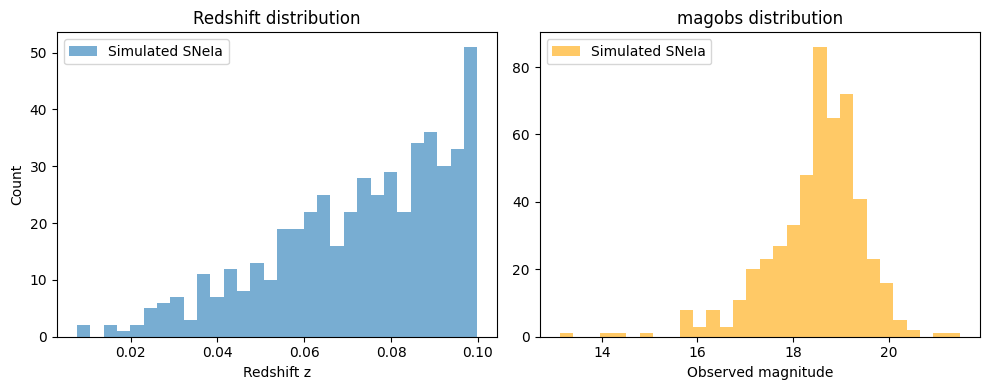

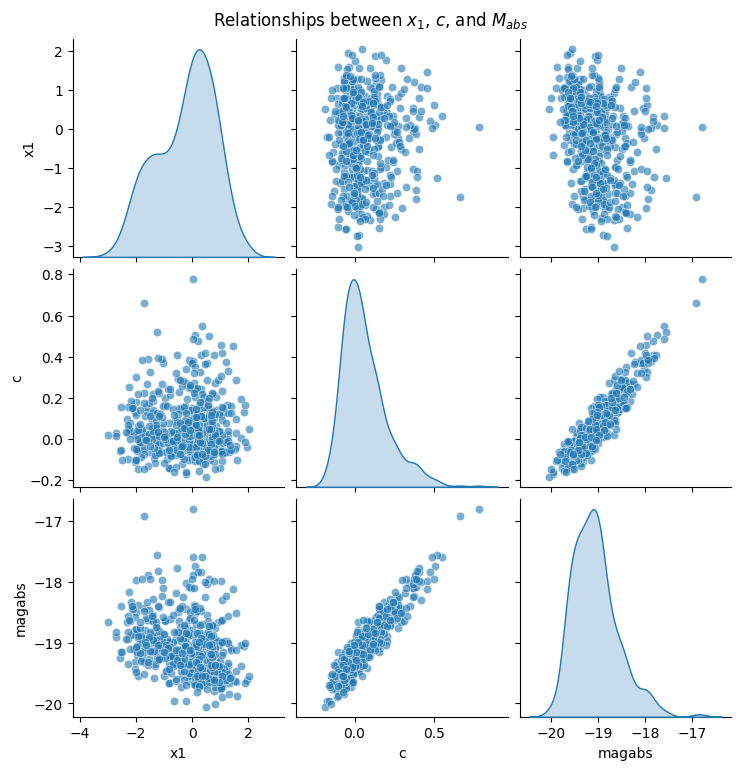

In [15]:
import matplotlib.pyplot as plt

# Histograma de redshift
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(snia.data["z"], bins=30, alpha=0.6, label="Simulated SNeIa")
plt.xlabel("Redshift z")
plt.ylabel("Count")
plt.title("Redshift distribution")
plt.legend()

# Histograma de magnitudes observadas
plt.subplot(1, 2, 2)
plt.hist(snia.data["magobs"], bins=30, alpha=0.6, label="Simulated SNeIa", color="orange")
plt.xlabel("Observed magnitude")
plt.title("magobs distribution")
plt.legend()

plt.tight_layout()
plt.show()

import seaborn as sns

# Filtramos solo las columnas relevantes
df_params = snia.data[["x1", "c", "magabs"]]

# Usamos pairplot para ver relaciones cruzadas
sns.pairplot(df_params, diag_kind="kde", plot_kws={"alpha": 0.6})
plt.suptitle("Relationships between $x_1$, $c$, and $M_{abs}$", y=1.02)
plt.show()


***

### Task 2: Simulate the light-curves for each SNIa

In [16]:
dset                    = skysurvey.DataSet.from_targets_and_survey(snia, ztf_survey)

### Exercise 2: Plot the light-curve of a well sampled light-curve
    * `dset.get_ndetection()[dset.get_ndetection()>100]` will help in the selection
    * _Extension_: find a corresponding object in the ZTF-DR2 dataset and compare

In [19]:
import matplotlib.pyplot as plt

# Obtener y graficar la curva de luz
lc = dset.get_lightcurve(good_idx)
ax = lc.plot()

# Guardar el gráfico como imagen
plt.savefig("simulated_lightcurve.png", dpi=300)
plt.show()

import numpy as np

# Coordenadas del objeto simulado
ra_sim = snia.data.loc[good_idx, 'ra']
dec_sim = snia.data.loc[good_idx, 'dec']

# Calcular separación (en grados)
logs_2019["sep"] = np.sqrt((logs_2019["ra"] - ra_sim)**2 + (logs_2019["dec"] - dec_sim)**2)

# Filtrar objetos cercanos (<0.1°)
match = logs_2019[logs_2019["sep"] < 0.1]
print(f"Se encontraron {len(match)} objetos reales cerca del objeto simulado")
match.head()

plt.hist(logs_2019["magpsf"], bins=50, alpha=0.5, label="ZTF DR2 (magpsf)")
plt.axvline(snia.data.loc[good_idx, "magobs"], color='red', label="Simulated SN magobs")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.legend()
plt.title("Comparación de magnitudes observadas")
plt.show()


AttributeError: 'DataSet' object has no attribute 'get_lightcurve'

***

### Task 3: For each light-curve, fit the SALT2 model
 * _NB_: This may be slow; if problems arise, then see the alternative approach below
 * Merge the two datasets so we can compare the input `truth` with the `observed` distributions

In [ ]:
dset.data["time"]          = dset.data["mjd"]
fit_results                = lcfit.fit_salt(dset)

In [ ]:
fit_results                    = fit_results.drop(columns={'z'})
fit_results                    = fit_results.drop(columns={'cov_t0c', 'cov_x0c', 'cov_x1c', 'cov_cc', 'cov_t0t0', \
                                                           'cov_x0x0', 'cov_x1x0', 'cov_cx0', 'cov_t0x1', 'cov_x0x1', \
                                                           'cov_x1x1', 'cov_cx1', 'cov_ct0', 'cov_t0x0', 'cov_x0t0', \
                                                           'cov_x1t0'})
fit_results                    = fit_results.rename(columns={'x1':'x1_fit','c':'c_fit','t0':'t0_fit','x0':'x0_fit'})
merged                         = snia.data.merge(fit_results,left_index=True, right_index=True)
# Consistently define the peak magnitude of the samples
merged['mB']                   = -2.5*np.log10(merged.x0) + 10.653
merged['mB_fit']               = -2.5*np.log10(merged.x0_fit.to_list()) + 10.653
merged.head()

,z,x1,c,t0,ra,dec,magabs,magobs,x0,template,c_fit,c_err,t0_fit,t0_err,x0_fit,x0_err,x1_fit,x1_err,mB,mB_fit
1,0.07425,-1.560,0.120,58537.281250,210.484802,31.299187,-18.834576,18.868404,0.000450,salt2,0.062815,0.076264,58536.189084,1.8745,0.000499,0.000081,-1.716563,0.31379,19.019793,18.907329
2,0.07355,0.115,-0.068,58555.539062,108.931969,-1.500204,-19.534184,18.147182,0.000875,salt2,-0.006707,0.050796,58557.371119,0.795849,0.000811,0.000045,-0.440986,0.76222,18.298571,18.379955
4,0.09105,-0.640,0.141,58579.636719,268.078644,-27.514948,-18.884733,19.285936,0.000306,salt2,0.003161,0.250761,58581.815121,5.919727,0.000329,0.000211,-1.010134,0.781435,19.437325,19.358920
5,0.03935,0.350,0.400,58611.281250,165.690140,1.402053,-18.302059,17.968733,0.001031,salt2,0.400066,0.032057,58611.283281,0.100565,0.001034,0.000038,0.262955,0.142809,18.120121,18.116790
9,0.08725,-0.065,0.024,58517.164062,232.010162,2.777110,-19.251743,18.820803,0.000470,salt2,-0.014072,0.046961,58516.51772,0.0012,0.000485,0.000031,-0.182209,0.597106,18.972191,18.938909


### A useful aside
 * If the above is too intensive, alternatively add noise to each parameter

In [ ]:
from ztfidr import simulation
noise_model                 = {'x1':simulation.noise_model['x1'], \
                               'c':simulation.noise_model['c'], \
                               'magobs':simulation.noise_model['magobs']}
sim                         = snia.apply_gaussian_noise(noise_model)
sim.data["magres_err"]      = sim.data["magobs_err"]

### Exercise 3: Plot the output values against the input values
    * Consider the parameters $x_1$,$c$,$m_B$

***

### Exercise 4: Compare the distributions of ($z$,$x_1$,$c$,$m_B$)
 * Compare the fitted values with those measured for the ZTF-DR2 sample
 * Where do they differ? Why?

***

### Task 4 : Include the effect of selection
 * Observational effects related to photometry have been considered
 * What about spectroscopy?
 * We use the parameterisation below

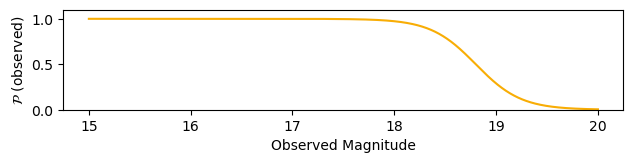

In [ ]:
def get_spectro_completness(mag, loc=18.7, scale=4.5):
    """ survival sigmoid function : 1- scipy.special.expit( (mag -loc)*scale) """
    mag = np.atleast_1d(mag)
    p_obs = 1-expit( (mag-loc) * scale)
    return p_obs
fig               = plt.figure(figsize=[7,4])
ax                = fig.add_axes([0.1,0.7, 0.8, 0.25])
dummy_mag         = np.linspace(15, 20, 1000)
_                 = ax.plot(dummy_mag, get_spectro_completness(dummy_mag, loc=18.8, scale=4.5), \
                            color="#F8AD05", ls="-", label="ZTF SN Ia DR2 selection funtion", )
_                 = ax.set_ylim(0, 1.1)
_                 = ax.set_xlabel('Observed Magnitude')
_                 = ax.set_ylabel(r"$\mathcal{P}$ (observed)")


### For each object, determine the probability that it was observed

In [ ]:
merged["p_obs"]     = get_spectro_completness(merged.mB_fit, loc=18.8, scale=4.5)

### Exercise 4: Include this effect
 * Remove all events with `p_obs<0.5`
 * Plot the distributions of $z$, $x_1$, $c$, $m_B$
 * How do they compare to the dataset?

***